### 1. Create Spark tables pointing to the Azure Cosmos DB Analytical Store collections using Azure Synapse Link 



In [ ]:
%%sql
create database CosmosDemoRetail

In [ ]:
%%sql

create table if not exists CosmosDemoRetail.RetailProducts
using cosmos.olap
options(spark.synapse.linkedService 'CosmosDemo',
        spark.cosmos.container 'RetailProducts')

In [ ]:
%%sql

create table if not exists CosmosDemoRetail.RetailSales
using cosmos.olap
options(spark.synapse.linkedService 'CosmosDemo',
        spark.cosmos.container 'RetailSales')

In [ ]:
%%sql

create table if not exists CosmosDemoRetail.RetailStoreDemographics
using cosmos.olap
options(spark.synapse.linkedService 'CosmosDemo',
        spark.cosmos.container 'RetailStoreDemographics')


### 2. Perform Joins across collections, apply filters and aggregations using Spark SQL from Azure Cosmos DB


In [1]:
data = spark.sql("select a.storeId \
                       , b.productCode \
                       , b.wholeSaleCost \
                       , b.basePrice \
                       , c.ratioAge60 \
                       , c.collegeRatio \
                       , c.income \
                       , c.highIncome150Ratio \
                       , c.largeHH \
                       , c.minoritiesRatio \
                       , c.more1FullTimeEmployeeRatio \
                       , c.distanceNearestWarehouse \
                       , c.salesNearestWarehousesRatio \
                       , c.avgDistanceNearest5Supermarkets \
                       , c.salesNearest5StoresRatio \
                       , a.quantity \
                       , a.logQuantity \
                       , a.advertising \
                       , a.price \
                       , a.weekStarting \
                 from CosmosDemoRetail.RetailSales a \
                 left join CosmosDemoRetail.RetailProducts b \
                 on a.productcode = b.productcode \
                 left join CosmosDemoRetail.RetailStoreDemographics c \
                 on a.storeId = c.storeId \
                 order by a.weekStarting, a.storeId, b.productCode")

display(data)

StatementMeta(sparkpool, 11, 3, Finished, Available)

SynapseWidget(Synapse.DataFrame, 831f4ff6-8364-42bd-9ff7-53d0c8f52b0b)

### 3. Azure Machine Learning's environment setup for AutoML to build a Forecasting Model


In [3]:
import azureml.core
import pandas as pd
import numpy as np
import logging
from azureml.core.workspace import Workspace
from azureml.core import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
import os
subscription_id = os.getenv("SUBSCRIPTION_ID", default="<SUBSCRIPTION_ID>")
resource_group = os.getenv("RESOURCE_GROUP", default="<RESOURCE_GROUP>")
workspace_name = os.getenv("WORKSPACE_NAME", default="<WORKSPACE_NAME>")
workspace_region = os.getenv("WORKSPACE_REGION", default="<WORKSPACE_REGION>")

ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
ws.write_config()
    
experiment_name = 'automl-surfaceforecasting'
experiment = Experiment(ws, experiment_name)
output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['SKU'] = ws.sku
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

StatementMeta(sparkpool, 11, 5, Finished, Available)

                                                      
Subscription ID   2386ed0e-ac2f-41c7-958a-7397006dce05
Workspace         kyowonmlworkspace                   
SKU               Basic                               
Resource Group    KyoWon_HoL                          
Location          koreacentral                        
Run History Name  automl-surfaceforecasting

### 4. Data Preparation - Feature engineering, Splitting train & test datasets



In [4]:
# Initial variables
time_column_name = 'weekStarting'
grain_column_names = ['storeId', 'productCode']
target_column_name = 'quantity'
use_stores = [2, 5, 8,71,102]
n_test_periods = 20


#DataFrame
df = data.toPandas()
df[time_column_name] = pd.to_datetime(df[time_column_name])
df['storeId'] = pd.to_numeric(df['storeId'])
df['quantity'] = pd.to_numeric(df['quantity'])
df['advertising'] = pd.to_numeric(df['advertising'])
df['price'] = df['price'].astype(float)
df['basePrice'] = df['basePrice'].astype(float)
df['ratioAge60'] = df['ratioAge60'].astype(float)
df['collegeRatio'] = df['collegeRatio'].astype(float)
df['highIncome150Ratio'] = df['highIncome150Ratio'].astype(float)
df['income'] = df['income'].astype(float)
df['largeHH'] = df['largeHH'].astype(float)
df['minoritiesRatio'] = df['minoritiesRatio'].astype(float)
df['logQuantity'] = df['logQuantity'].astype(float)
df['more1FullTimeEmployeeRatio'] = df['more1FullTimeEmployeeRatio'].astype(float)
df['distanceNearestWarehouse'] = df['distanceNearestWarehouse'].astype(float)
df['salesNearestWarehousesRatio'] = df['salesNearestWarehousesRatio'].astype(float)
df['avgDistanceNearest5Supermarkets'] = df['avgDistanceNearest5Supermarkets'].astype(float)
df['salesNearest5StoresRatio'] = df['salesNearest5StoresRatio'].astype(float)


# Time Series
data_subset = df[df.storeId.isin(use_stores)]
nseries = data_subset.groupby(grain_column_names).ngroups
print('Data subset contains {0} individual time-series.'.format(nseries))

# Group by date
def split_last_n_by_grain(df, n):
    """Group df by grain and split on last n rows for each group."""
    df_grouped = (df.sort_values(time_column_name) # Sort by ascending time
                  .groupby(grain_column_names, group_keys=False))
    df_head = df_grouped.apply(lambda dfg: dfg.iloc[:-n])
    df_tail = df_grouped.apply(lambda dfg: dfg.iloc[-n:])
    return df_head, df_tail

# splitting
train, test = split_last_n_by_grain(data_subset, n_test_periods)
print(len(train),len(test))
train.to_csv (r'./SurfaceSales_train.csv', index = None, header=True)
test.to_csv (r'./SurfaceSales_test.csv', index = None, header=True)
datastore = ws.get_default_datastore()
datastore.upload_files(files = ['./SurfaceSales_train.csv', './SurfaceSales_test.csv'], target_path = 'dataset/', overwrite = True,show_progress = True)

# loading the train dataset
from azureml.core.dataset import Dataset
train_dataset = Dataset.Tabular.from_delimited_files(path=datastore.path('dataset/SurfaceSales_train.csv'))

StatementMeta(sparkpool, 11, 6, Finished, Available)

Data subset contains 15 individual time-series.
1422 300
Uploading an estimated of 2 files
Uploading ./SurfaceSales_train.csv
Uploaded ./SurfaceSales_train.csv, 1 files out of an estimated total of 2
Uploading ./SurfaceSales_test.csv
Uploaded ./SurfaceSales_test.csv, 2 files out of an estimated total of 2
Uploaded 2 files

### 5. Training the Models using AutoML Forecasting

Please notice that **compute_target** is commented, meaning that the model training will run locally in Synapse Spark.


In [5]:
# Parameters
time_series_settings = {
    'time_column_name': time_column_name,
    'grain_column_names': grain_column_names,
    'max_horizon': n_test_periods
}

# Config
automl_config = AutoMLConfig(task='forecasting',
                             debug_log='automl_ss_sales_errors.log',
                             primary_metric='normalized_mean_absolute_error',
                             experiment_timeout_hours=0.5,
                             training_data=train_dataset,
                             label_column_name=target_column_name,
                             #compute_target=compute_target,
                             enable_early_stopping=True,
                             n_cross_validations=3,
                             verbosity=logging.INFO,
                             **time_series_settings)

# Running the training
remote_run = experiment.submit(automl_config, show_output=True)

StatementMeta(sparkpool, 11, 7, Finished, Available)

Running on local machine
Parent Run ID: AutoML_9569e0cd-e9de-486f-ba15-28abdd23f9e1

Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Frequency detection
STATUS:       PASSED
DESCRIPTION:  The 

### 6. Retrieving the Best Model and Forecasting


In [6]:
# Retrieving the best model
best_run, fitted_model = remote_run.get_output()
print(fitted_model.steps)
model_name = best_run.properties['model_name']
print(model_name)

# Forecasting based on test dataset
X_test = test
y_test = X_test.pop(target_column_name).values
X_test[time_column_name] = pd.to_datetime(X_test[time_column_name])
y_predictions, X_trans = fitted_model.forecast(X_test)

StatementMeta(sparkpool, 11, 8, Finished, Available)

[('timeseriestransformer', TimeSeriesTransformer(featurization_config=None,
                      pipeline_type=<TimeSeriesPipelineType.FULL: 1>)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('13',
                                          Pipeline(memory=None,
                                                   steps=[('robustscaler',
                                                           RobustScaler(copy=True,
                                                                        quantile_range=[10,
                                                                                        90],
                                                                        with_centering=True,
                                                                        with_scaling=False)),
                                                          ('decisiontreeregressor',
                                                           DecisionTreeRegressor(ccp_alpha=0.

### 7. Plotting the Results

At this point you should have a chart that created with AutoML and MatplotLib. 

The results are that good because of the **logQuantity** column, a  data Leakage calculated from **quantity** column. You can try to run the same experiment without it.


StatementMeta(sparkpool, 11, 9, Finished, Available)

[Test data scores]

root_mean_squared_error:   26.992
normalized_root_mean_squared_error:   0.016
normalized_root_mean_squared_log_error:   0.007
r2_score:   0.990
root_mean_squared_log_error:   0.036
explained_variance:   0.990
median_absolute_error:   1.185
mean_absolute_error:   8.534
mean_absolute_percentage_error:   2.246
normalized_mean_absolute_error:   0.005
spearman_correlation:   1.000
normalized_median_absolute_error:   0.001


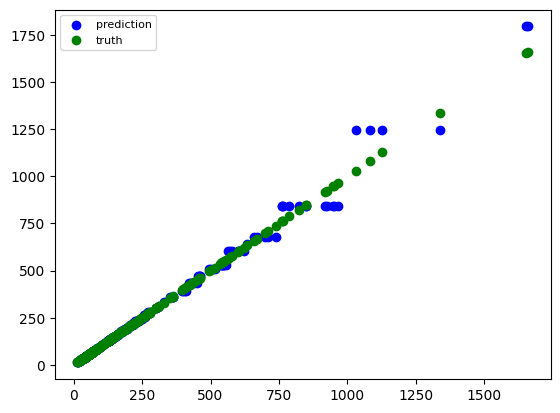

In [7]:
import pandas as pd
import numpy as np
from pandas.tseries.frequencies import to_offset


def align_outputs(y_predicted, X_trans, X_test, y_test, target_column_name,
                  predicted_column_name='predicted',
                  horizon_colname='horizon_origin'):
    """
    Demonstrates how to get the output aligned to the inputs
    using pandas indexes. Helps understand what happened if
    the output's shape differs from the input shape, or if
    the data got re-sorted by time and grain during forecasting.

    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """

    if (horizon_colname in X_trans):
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted,
                                horizon_colname: X_trans[horizon_colname]})
    else:
        df_fcst = pd.DataFrame({predicted_column_name: y_predicted})

    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index

    # align original X_test to y_test
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's index does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')

    # drop rows where prediction or actuals are nan
    # happens because of missing actuals
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name,
                               predicted_column_name]].notnull().all(axis=1)]
    return(clean)


df_all = align_outputs(y_predictions, X_trans, X_test, y_test, target_column_name)

from azureml.automl.core._vendor.automl.client.core.common import metrics
from matplotlib import pyplot as plt
from automl.client.core.common import constants

# use automl metrics module
scores = metrics.compute_metrics_regression(
    df_all['predicted'],
    df_all[target_column_name],
    list(constants.Metric.SCALAR_REGRESSION_SET),
    None, None, None)

print("[Test data scores]\n")
for key, value in scores.items():    
    print('{}:   {:.3f}'.format(key, value))
    
# Plot outputs
#%matplotlib inline
test_pred = plt.scatter(df_all[target_column_name], df_all['predicted'], color='b')
test_test = plt.scatter(df_all[target_column_name], df_all[target_column_name], color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

### 8. Register Model

In [8]:
model_name = best_run.properties['model_name']

script_file_name = 'inference/score.py'
conda_env_file_name = 'inference/env.yml'

best_run.download_file('outputs/scoring_file_v_1_0_0.py', 'inference/score.py')
best_run.download_file('outputs/conda_env_v_1_0_0.yml', 'inference/env.yml')

registered_model = remote_run.register_model(model_name = model_name)

print(remote_run.model_id)

StatementMeta(sparkpool, 11, 10, Finished, Available)

AutoML9569e0cde30

### 9. Deploy Web Service as Azure Container Instance

In [9]:
from azureml.core.webservice import AciWebservice, Webservice

aci_config = AciWebservice.deploy_configuration(
   cpu_cores = 1, 
   memory_gb = 2, 
   tags = {'name':'scoring'}, 
   description = 'Scoring web service')

from azureml.core.model import InferenceConfig
inference_config = InferenceConfig(runtime="python", 
                                       entry_script=script_file_name,
                                       conda_file=conda_env_file_name)

from azureml.core.model import Model
webservice = Model.deploy(workspace=ws,
                              name="scoringservice",
                              models=[registered_model],
                              inference_config=inference_config,
                              deployment_config=aci_config)

StatementMeta(sparkpool, 11, 11, Finished, Available)